## Imports

In [1]:
import numpy as np
import torch

## Configuration

In [2]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Dataset
    "dataset": "CIFAR-10-LT",
    "image_size": 32,
    "num_classes": 10,
    "valid_transform_reprs": ["ToTensor()"],

    # Mean and std for normalization
    "normalize_mean": [0.4914, 0.4822, 0.4465],
    "normalize_std": [0.2023, 0.1994, 0.2010],

    # DataLoader
    "batch_size": 128,
    "num_workers": 8,
    "enable_pin_memory": True,
    "checkpoint_url": "https://drive.google.com/uc?id=1ZEaevP97mXYdLU_Jv6S5sm2oR3TZZLeF",
    
    # Model
    "model": "WideResNet-28-10-torchdistill",
    "dropout_rate": 0.3,

    # OPeN
    "pure_noise_image_size": 32,
    "pure_noise_mean": [0.4914, 0.4822, 0.4465],
    "pure_noise_std": [0.2498, 0.2480, 0.2718],

    # BN
    "noise_bn_option": "DARBN",
    
    # t-SNE
    "per_class_count": 50,
    
    # Checkpoint
    "checkpoint_filename": "CIFAR10IR100-open__epoch_199.pt",
})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [4]:
import os
import gdown
from storage import CHECKPOINT_URLS

checkpoint_filepath = f"checkpoints/{CONFIG.checkpoint_filename}"
if not os.path.exists(checkpoint_filepath):
    gdown.download(CHECKPOINT_URLS[CONFIG.checkpoint_filename], checkpoint_filepath, quiet=False)

## Set Random Seed

In [5]:
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Initialize Model

In [6]:
from initializers import initialize_model, InputNormalize
from models.noise_bn_option import NoiseBnOption

net = initialize_model(
    model_name=CONFIG.model, 
    num_classes=CONFIG.num_classes, 
    noise_bn_option=NoiseBnOption[CONFIG.noise_bn_option],
    dropout_rate=CONFIG.dropout_rate)
net = net.to(device)

normalizer = InputNormalize(
    torch.Tensor(CONFIG.normalize_mean).to(device), 
    torch.Tensor(CONFIG.normalize_std).to(device)
).to(device)

In [7]:
from checkpointing import load_checkpoint

load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)

In [8]:
import torch.nn as nn

embedding_net = nn.Sequential(*list(net.children())[:-1])
embedding_net = embedding_net.to(device)
embedding_net = embedding_net.eval()

## Generate Pure Noise Images

In [9]:
from replace_with_pure_noise import sample_noise_images

noise_images = sample_noise_images(
    image_size=CONFIG.pure_noise_image_size,
    mean=CONFIG.pure_noise_mean,
    std=CONFIG.pure_noise_std, 
    count=CONFIG.per_class_count,
)
noise_images = noise_images.to(device)

## Load Dataset

In [10]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from initializers import initialize_transforms

DATA_ROOT = "./data"
valid_transform = initialize_transforms(CONFIG.valid_transform_reprs)
valid_dataset = CIFAR10(root=DATA_ROOT, train=False, transform=valid_transform, download=True)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=CONFIG.enable_pin_memory,
)

Files already downloaded and verified


## Generate Embeddings

### Noise

In [11]:
with torch.no_grad():
    noise_image_outputs = embedding_net(noise_images)
    noise_image_outputs = noise_image_outputs.cpu().numpy()

noise_image_labels = np.array([CONFIG.num_classes] * CONFIG.per_class_count)

In [12]:
noise_image_outputs.shape, noise_image_labels.shape

((50, 640, 1, 1), (50,))

### Validation Set

In [13]:
# Get all the data
with torch.no_grad():
    valid_inputs = []
    valid_labels = []
    for minibatch_i, (inputs, labels) in enumerate(valid_loader):
        inputs = inputs.float().to(device)
        inputs = normalizer(inputs)
        labels = labels.to(device)

        valid_inputs.extend(inputs.cpu().tolist())
        valid_labels.extend(labels.cpu().tolist())

    valid_inputs = np.array(valid_inputs)
    valid_labels = np.array(valid_labels)

In [14]:
# Get few data examples for each class
with torch.no_grad():
    valid_subset_outputs = []
    valid_subset_labels = []
    for class_ in np.arange(CONFIG.num_classes):
        random_indices = np.random.choice(1000, CONFIG.per_class_count)
        per_class_inputs = valid_inputs[valid_labels == class_][random_indices]
        per_class_labels = valid_labels[valid_labels == class_][random_indices]

        per_class_inputs = torch.FloatTensor(per_class_inputs).to(device)
        per_class_labels = torch.FloatTensor(per_class_labels).to(device)

        per_class_outputs = embedding_net(per_class_inputs)
        valid_subset_outputs.extend(per_class_outputs.cpu().tolist())
        valid_subset_labels.extend(per_class_labels.cpu().tolist())

    valid_subset_outputs = np.array(valid_subset_outputs)
    valid_subset_labels = np.array(valid_subset_labels)

In [15]:
valid_subset_outputs.shape, valid_subset_labels.shape

((500, 640, 1, 1), (500,))

## Run TSNE

In [16]:
outputs = np.concatenate([valid_subset_outputs, noise_image_outputs], axis=0)[:, :, 0, 0]
labels = np.concatenate([valid_subset_labels, noise_image_labels], axis=0)

In [17]:
from sklearn.manifold import TSNE

outputs_tsne = TSNE(random_state=0).fit_transform(outputs)

## Plot TSNE

In [18]:
import matplotlib

cmap = matplotlib.cm.get_cmap("Set3")
colors = [cmap(i) for i in np.linspace(0, 1, 11)]

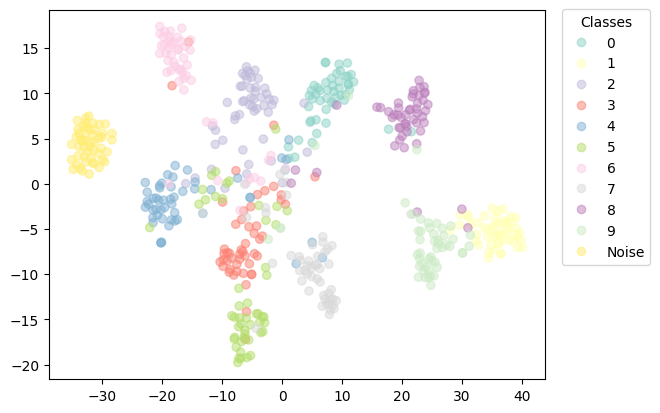

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sc = ax.scatter(
    x=outputs_tsne[:, 0],
    y=outputs_tsne[:, 1],
    c=labels,
    alpha=0.5,
    cmap="Set3",
)
# produce a legend with the unique colors from the scatter
legend_elements = sc.legend_elements()
legend_elements[1][-1] = "Noise"
plt.legend(*legend_elements, loc="upper left", title="Classes", bbox_to_anchor=(1.02, 1.02))
# ax.set_title("t-SNE of validation set with random noise images")
fig.savefig("tsne.png", bbox_inches='tight')
fig.show()

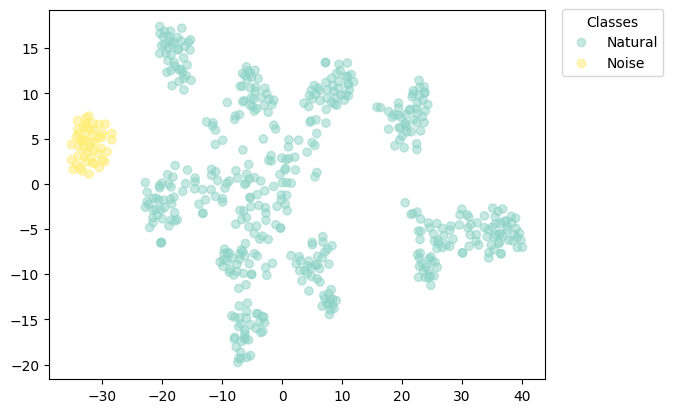

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sc = ax.scatter(
    x=outputs_tsne[:, 0],
    y=outputs_tsne[:, 1],
    c=[1 if label == 10 else 0 for label in labels],
    alpha=0.5,
    cmap="Set3",
)
# produce a legend with the unique colors from the scatter
legend_elements = sc.legend_elements()
legend_elements[1][0] = "Natural"
legend_elements[1][-1] = "Noise"
plt.legend(*legend_elements, loc="upper left", title="Classes", bbox_to_anchor=(1.02, 1.02))
# ax.set_title("t-SNE of validation set with random noise images")
fig.savefig("tsne_binary.png", bbox_inches='tight')
fig.show()